In [1]:
import torch
import numpy as np
import glob
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import os
from rasterio.warp import calculate_default_transform, reproject, Resampling
import shutil

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def normalize_band(band, stretch_factor=1.5):
    """
    Normalizes a band and stretches contrast.

    Args:
        band: A numpy array representing the band data.
        stretch_factor: A factor to control the amount of contrast stretching (default: 1.5).

    Returns:
        A numpy array with normalized and stretched band values.
    """
    return (band - band.min()) / (band.max() - band.min()) * stretch_factor

In [3]:
def add_padding_to_multiple_of_512(input_array):
    """
    Adiciona padding a um array numpy para garantir que suas dimensões de altura e largura
    sejam múltiplos de 512.

    Parâmetro:
    - input_array (numpy.ndarray): Array de entrada com formato (num_bands, H, W)

    Retorna:
    - numpy.ndarray: Array com padding adicionado, se necessário.
    - int: Padding aplicado na altura (H)
    - int: Padding aplicado na largura (W)
    """
    # Obtém as dimensões de altura (H) e largura (W) do array
    height, width = input_array.shape

    # Calcula o padding necessário para a altura e largura para que sejam múltiplos de 512
    pad_height = (512 - height % 512) if height % 512 != 0 else 0
    pad_width = (512 - width % 512) if width % 512 != 0 else 0

    # Aplica o padding usando np.pad. A ordem do padding é (before, after) para cada dimensão
    # O padding deve ser aplicado na ordem: (bands, height, width)
    # Aqui adicionamos o padding apenas nas dimensões de altura e largura (H, W)
    padded_array = np.pad(
        input_array,
        (
            (0, pad_height),  # Padding para a altura (H)
            (0, pad_width),
        ),  # Padding para a largura (W)
        mode="constant",
        constant_values=0,
    )

    return padded_array


# Função para ler as 13 bandas de uma imagem Sentinel-2 e retornar como um array
def read_and_resample_sentinel_bands(image_dir, target_resolution=10):
    """
    Lê as bandas do Sentinel-2 e reamostra todas para a resolução espacial de 10m, mantendo a ordem das bandas.

    Parâmetro:
    - image_dir: Diretório contendo as imagens .jp2
    - target_resolution: Resolução espacial desejada (padrão: 10m)

    Retorna:
    - numpy array com as 13 bandas reamostradas e organizadas na ordem correta.
    """
    # Lista para armazenar as bandas na ordem correta
    bands = [None] * 13  # Inicializa a lista com 13 posições (para as 13 bandas)

    # Primeiro, garante que a banda B02 será usada como referência
    reference_band_path = glob.glob(os.path.join(image_dir, "*B02.jp2"))
    if not reference_band_path:
        raise ValueError("A banda B02 (referência) não foi encontrada.")

    # Abre a banda de referência B02 para determinar os limites e resolução
    with rasterio.open(reference_band_path[0]) as reference_band:
        reference_transform = reference_band.transform
        reference_bounds = reference_band.bounds
        reference_crs = reference_band.crs
        reference_width = reference_band.width
        reference_height = reference_band.height
        left, bottom, right, top = reference_bounds
        print(f"Banda de referência B02 encontrada: {reference_band_path[0]}")

        # Adiciona a banda B02 diretamente na posição 1 (índice 1)
        bands[1] = add_padding_to_multiple_of_512(reference_band.read(1))

    # Padrão dos arquivos JP2 (procuramos arquivos que terminam com BXX.jp2, exceto B02 que já foi processada)
    band_patterns = {
        "B01": 0,
        "B03": 2,
        "B04": 3,
        "B05": 4,
        "B06": 5,
        "B07": 6,
        "B08": 7,
        "B8A": 8,
        "B09": 9,
        "B10": 10,
        "B11": 11,
        "B12": 12,
    }

    for band_name, index in band_patterns.items():
        # Procura no diretório o arquivo que termina com o padrão
        band_path = glob.glob(os.path.join(image_dir, f"*{band_name}.jp2"))

        if band_path:
            with rasterio.open(band_path[0]) as src:
                # Se a resolução da banda for diferente da resolução alvo, faz o reamostramento
                if src.res[0] != target_resolution or src.res[1] != target_resolution:
                    # print(f"Reamostrando {band_path[0]} para {target_resolution}m...")

                    # Calcula o transform e o shape para a nova resolução, utilizando os limites da referência
                    transform, width, height = calculate_default_transform(
                        src.crs,
                        reference_crs,
                        src.width,
                        src.height,
                        left=left,
                        bottom=bottom,
                        right=right,
                        top=top,
                        resolution=(target_resolution, target_resolution),
                    )

                    # Cria um array para armazenar a banda reamostrada
                    reprojected_band = np.empty((height, width), dtype=np.float32)

                    # Reamostra a banda usando rasterio.warp.reproject
                    reproject(
                        source=rasterio.band(src, 1),
                        destination=reprojected_band,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=reference_crs,
                        resampling=Resampling.nearest,  # Usa interpolação por vizinho mais próximo para reamostragem
                    )

                    bands[index] = add_padding_to_multiple_of_512(reprojected_band)
                else:
                    # Caso a resolução já seja 10m, apenas lê a banda
                    bands[index] = add_padding_to_multiple_of_512(src.read(1))
        else:
            print(f"Arquivo para o padrão {band_name} não encontrado.")

    # Verifica se todas as bandas foram preenchidas corretamente
    if any(band is None for band in bands):
        raise ValueError(
            "Algumas bandas não foram encontradas ou processadas corretamente."
        )

    # Converte a lista de bandas em um array numpy (shape: 13 x H x W)
    bands_array = np.stack(bands, axis=0)

    return bands_array


# Função para preparar os dados e enviar ao modelo (ajustando dimensões conforme necessário)
def prepare_for_model(bands_array):
    # Converter o array numpy para um tensor PyTorch (shape: 1 x 13 x H x W)
    bands_tensor = torch.from_numpy(bands_array).float().unsqueeze(0)

    return bands_tensor

In [4]:
def divide_image_into_tiles(image_array, tile_size=512, overlap=0):
    """
    Divide a imagem em tiles de tamanho especificado com sobreposição opcional.

    Parâmetros:
    - image_array: numpy array com as bandas da imagem (C, H, W)
    - tile_size: tamanho do tile (padrão: 512)
    - overlap: quantidade de pixels de sobreposição entre os tiles (padrão: 0)

    Retorna:
    - Lista de tiles (sub-imagens) e suas coordenadas.
    """
    _, height, width = image_array.shape
    stride = tile_size - overlap
    tiles = []
    coords = []

    for i in range(0, height, stride):
        for j in range(0, width, stride):
            # Calcula o índice final do tile
            i_end = min(i + tile_size, height)
            j_end = min(j + tile_size, width)

            # Extrai o tile
            tile = image_array[:, i:i_end, j:j_end]

            # Armazena o tile e as coordenadas de onde ele veio
            tiles.append(tile)
            coords.append((i, j))

    return tiles, coords


def save_tiles(tiles, output_dir, prefix="tile"):
    """
    Salva os tiles como arquivos .npy no diretório especificado.

    Parâmetros:
    - tiles: lista de numpy arrays dos tiles
    - output_dir: diretório para salvar os arquivos
    - prefix: prefixo para o nome dos arquivos
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for idx, tile in enumerate(tiles):
        np.save(os.path.join(output_dir, f"{prefix}_{idx}.npy"), tile)


def generate_masks_for_tiles(tiles, model, tile_size=512):
    """
    Lê os tiles do diretório, passa pelo modelo e salva as máscaras geradas.

    Parâmetros:
    - tiles_dir: diretório contendo os tiles .npy
    - model: modelo de segmentação a ser usado
    - mask_output_dir: diretório para salvar as máscaras geradas
    - tile_size: tamanho dos tiles (padrão: 512)
    """

    masks = []

    for idx, tile in enumerate(tiles):

        with torch.no_grad():
            model.eval()
            tile = prepare_for_model(tile)
            logits = model(tile)
        # pr_masks = logits.sigmoid()
        pr_masks = F.softmax(logits, dim=1)
        mask = torch.argmax(pr_masks, dim=1)

        # Salva a máscara
        masks.append(mask)

    return masks


def reconstruct_mask_from_tiles(masks, coords, image_shape, tile_size=512):
    """
    Reconstrói a máscara final a partir dos tiles processados.

    Parâmetros:
    - mask_dir: diretório contendo as máscaras dos tiles
    - coords: lista de coordenadas dos tiles (índice inicial em (H, W))
    - image_shape: formato da imagem original (H, W)
    - tile_size: tamanho dos tiles (padrão: 512)

    Retorna:
    - numpy array da máscara final (H, W).
    """
    final_mask = np.zeros(image_shape, dtype=np.float32)

    for idx, mask in enumerate(masks):

        i, j = coords[idx]

        i_end = i + tile_size
        j_end = j + tile_size

        # Preenche a máscara final com o tile correspondente
        final_mask[i:i_end, j:j_end] = mask

    return final_mask


def save_final_mask(mask, output_path):
    """
    Salva a máscara final como arquivo .npy ou .tif.

    Parâmetros:
    - mask: numpy array da máscara final
    - output_path: caminho para salvar a máscara
    """
    np.save(output_path, mask)


def salvar_mascara_tiff(
    mascara: np.ndarray, banda_exemplo_path: str, output_path: str
) -> None:
    """
    Saves a mask as a TIFF file with georeferencing.
    """
    with rasterio.open(banda_exemplo_path) as src:
        transform = src.transform
        crs = src.crs
        profile = src.profile

        profile.update(dtype=rasterio.uint16, count=1, compress="lzw")

        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(mascara.astype(rasterio.uint16), 1)

In [5]:
def cloud_mask_pipeline(image_dir: str):

    # Ler as 13 bandas e prepará-las para o modelo
    padded_array = (read_and_resample_sentinel_bands(image_dir) - 1000) / 10000
    padded_array = padded_array.clip(min=0)
    print(
        f"Padded shape: {padded_array.shape} - Max={padded_array.max()} - Min={padded_array.min()}"
    )

    tiles, coords = divide_image_into_tiles(padded_array, tile_size=512, overlap=0)
    padded_height, padded_width = padded_array.shape[1:]
    del padded_array

    # Load the model from the local directory
    model = smp.from_pretrained(
        r"G:\Meu Drive\Unet\lightning_logs\Unet_efficientnet-b0\Unet_efficientnet-b0"
    )

    masks = generate_masks_for_tiles(tiles, model)
    del tiles

    final_mask = reconstruct_mask_from_tiles(
        masks, coords, (padded_height, padded_width)
    )

    band_ref = glob.glob(os.path.join(image_dir, f"*B02.jp2"))[0]

    img_path = band_ref.replace("B02.jp2", "mask2.tif")

    salvar_mascara_tiff(final_mask, band_ref, img_path)

    colors = {
        0: "black",  # Limpo
        1: "white",  # Nuvem
        2: "yellow",  # Nuvem Fina
        3: "gray",  # Sombra de Nuvem
    }

    labels = ["Limpo", "Nuvem", "Nuvem Fina", "Sombra de Nuvem"]  # 0  # 1  # 2  # 3
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
    TCI = glob.glob(os.path.join(image_dir, f"*TCI.jp2"))[0]
    TCI = rasterio.open(TCI).read()
    ax[0].imshow(TCI.transpose(1, 2, 0))

    mascara_de_classificacao = final_mask.astype(dtype=np.int16)

    max_color_len = max(len(color) for color in colors.values())

    # Cria uma lista de cores para a visualização usando Matplotlib
    cmap = ListedColormap([colors[i] for i in colors])

    im = ax[1].imshow(
        mascara_de_classificacao[0 : TCI.shape[1], 0 : TCI.shape[2]],
        cmap=cmap,
        interpolation="none",
        vmin=0,
        vmax=max(colors) + 0.05,
    )
    plt.show()

Banda de referência B02 encontrada: D:\Imagens_Carbonext\awa\S2A_MSIL1C_20231109T134701_N0509_R024_T22MDD_20231109T153154.SAFE\GRANULE\L1C_T22MDD_A043779_20231109T134703\IMG_DATA\T22MDD_20231109T134701_B02.jp2
Padded shape: (13, 11264, 11264) - Max=1.5073000192642212 - Min=0.0
Loading weights from local directory


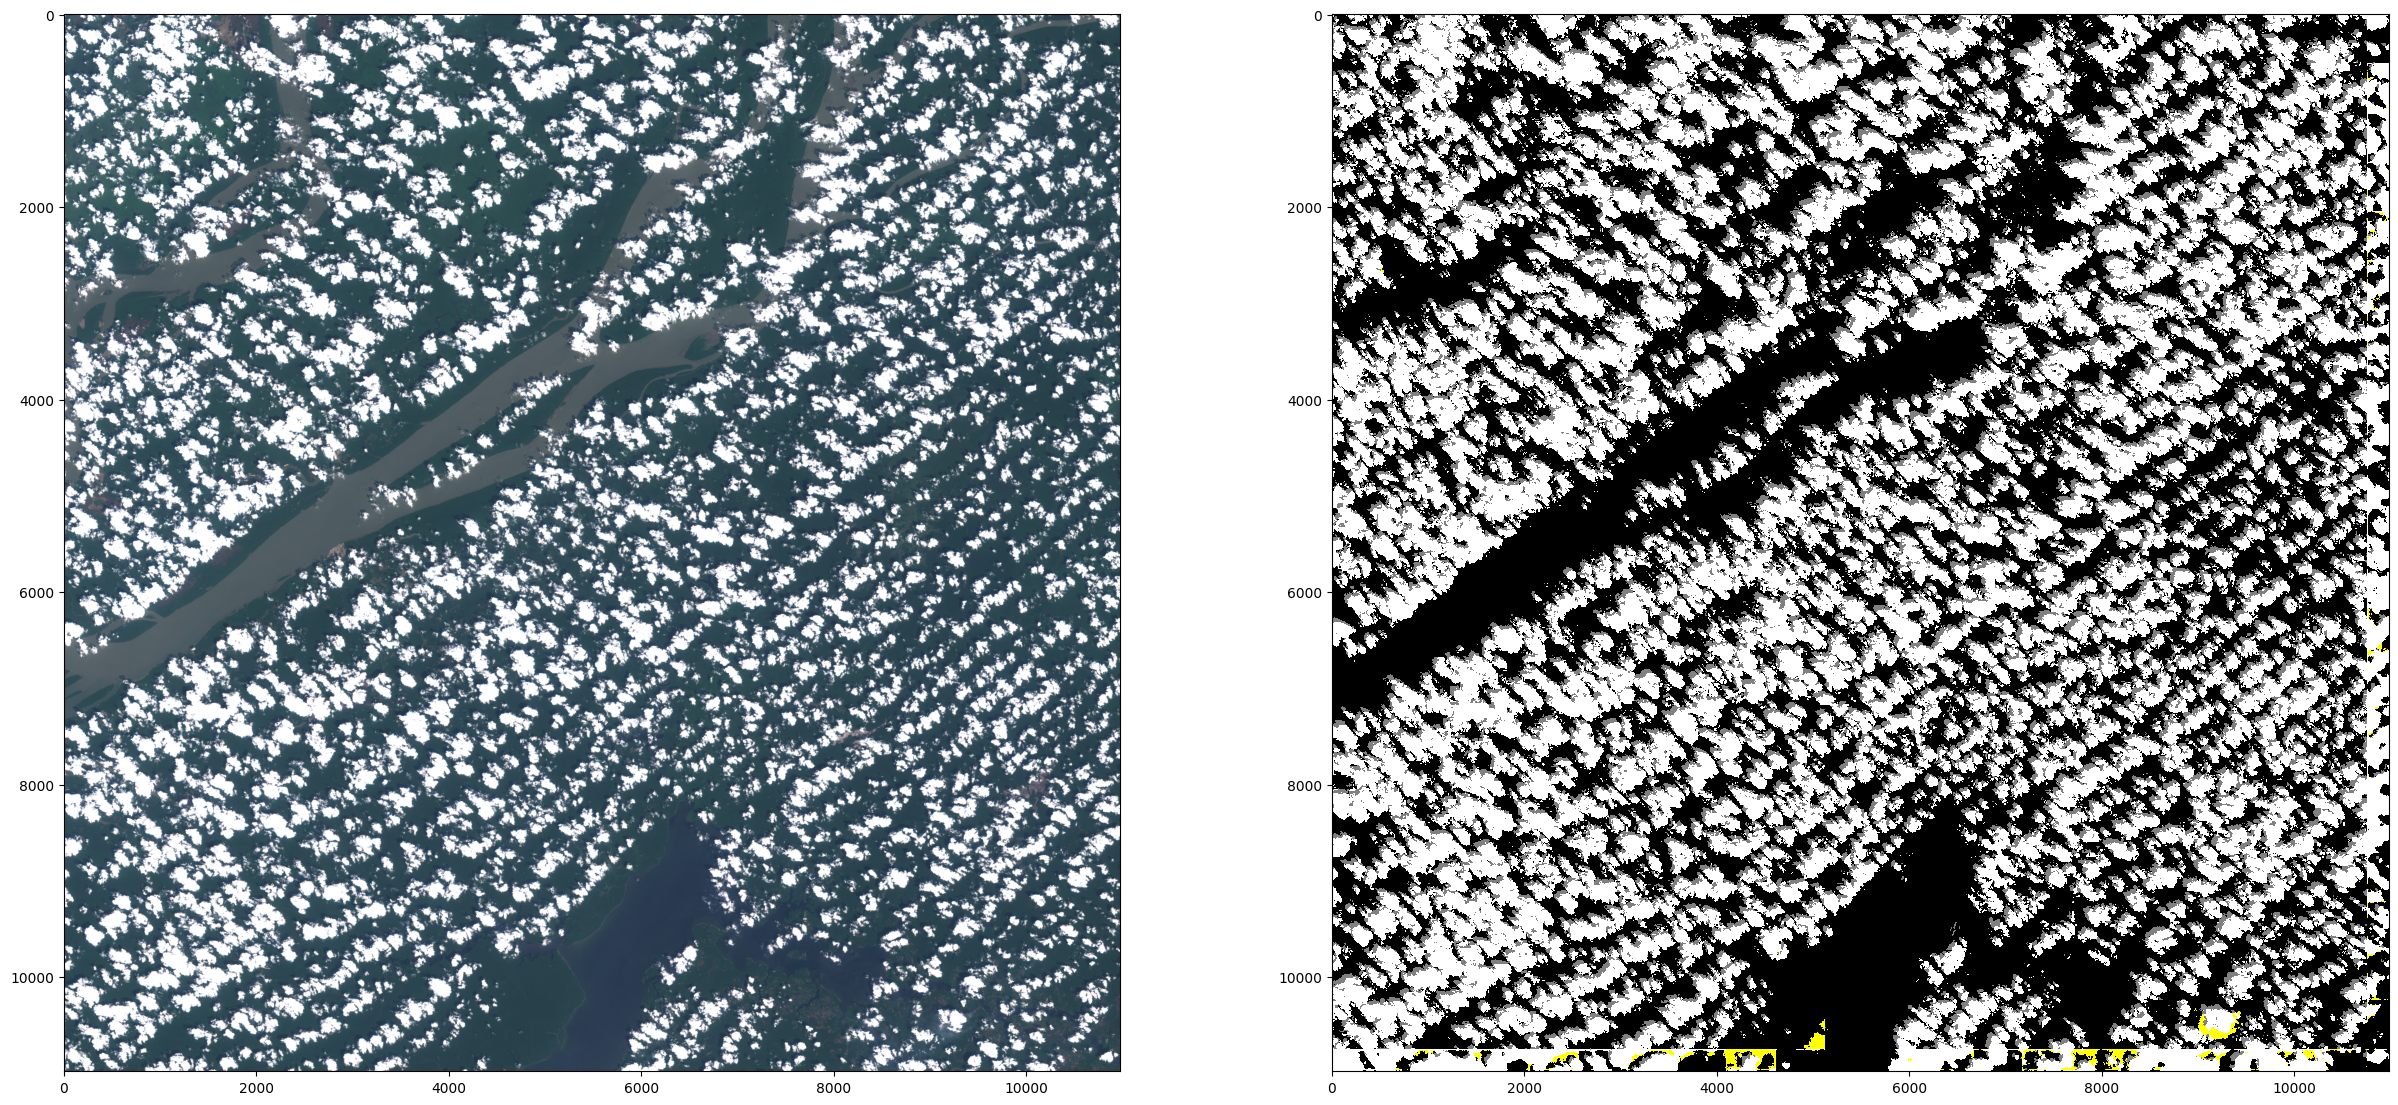

In [6]:
def listar_diretorios(diretorio):
    # Lista todos os itens dentro do diretório
    itens = os.listdir(diretorio)

    # Filtra apenas os diretórios
    subdiretorios = [
        item for item in itens if os.path.isdir(os.path.join(diretorio, item))
    ]

    return subdiretorios


# Exemplo de uso
diretorio_entrada = r"D:\Imagens_Carbonext\awa\S2A_MSIL1C_20231109T134701_N0509_R024_T22MDD_20231109T153154.SAFE\GRANULE\L1C_T22MDD_A043779_20231109T134703\IMG_DATA"
#dir_images = listar_diretorios(diretorio_entrada)

'''
for dir in dir_images:
    img_data_path = os.path.join(diretorio_entrada, dir, "GRANULE")
    next_dir = os.listdir(img_data_path)[0]
    img_data_path = os.path.join(img_data_path, next_dir, "IMG_DATA")
'''
cloud_mask_pipeline(diretorio_entrada)